In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def infer(image):
    pass
        
def train():
    pass
        
def evaluate():
    pass

In [7]:
def load_dataset(batch_size):
    train, test = tf.keras.datasets.mnist.load_data()
    return tf.data.Dataset.from_tensor_slices(train).shuffle(100).repeat().batch(batch_size), \
           tf.data.Dataset.from_tensor_slices(test).shuffle(100).repeat().batch(batch_size)
data_train, data_test = load_dataset(100)

batch_size = tf.placeholder(tf.int64)
x, y = tf.placeholder(tf.float32, [None, None, None, 1]), tf.placeholder(tf.float32, [None])
dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size).repeat()

In [4]:
def get_model(dataset):
    itr = dataset.make_one_shot_iterator()
    x, y = itr.get_next()

    #x_ph = tf.placeholder(tf.float32, [None, None, None, 1])
    #y_ph = tf.placeholder(tf.int64, [None])
    
    conv_1 = tf.layers.conv2d(x, 512, 3)
    pool_1 = tf.layers.max_pooling2d(conv_1, 4, 2)
    bn_1   = tf.contrib.layers.batch_norm(pool_1)

    conv_2 = tf.layers.conv2d(bn_1, 1024, 3)
    pool_2 = tf.layers.max_pooling2d(conv_2, 4, 2)
    bn_2   = tf.contrib.layers.batch_norm(pool_2)

    conv_3 = tf.layers.conv2d(bn_2, 10, 1)
    logits = tf.reduce_mean(conv_3, axis=[1, 2])
    
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
    
    train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
    
    # evaluate the accuracy of the model
    correct_prediction = tf.equal(tf.argmax(logits, 1), y_ph)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar("loss", cross_entropy)
    #tf.summary.scalar('accuracy', accuracy)
    merged = tf.summary.merge_all()

    return train_step, accuracy, merged, x_ph, y_ph, logits
    
train_step, accuracy, merged, x_ph, y_ph, logits = get_model()

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

file_writer = tf.summary.FileWriter("./logs", sess.graph)

for i in range(1000):
    batch_xs, batch_ys = data.train.next_batch(100)
    batch_xs = np.reshape(batch_xs, [-1, 28, 28, 1])
    
    sess.run(iter.initializer, feed_dict={ x: train_data[0], y: train_data[1], batch_size: BATCH_SIZE})
    
    summary, _ = sess.run([merged, train_step], feed_dict={ x_ph: batch_xs, y_ph: batch_ys })
    file_writer.add_summary(summary, i)
file_writer.close()

In [6]:
total_accuracy = 0.0
for i in range(100):
    batch_xs, batch_ys = data.test.next_batch(100)
    batch_xs = np.reshape(batch_xs, [-1, 28, 28, 1])
    acc = sess.run(accuracy, feed_dict={x_ph: batch_xs, y_ph: batch_ys})
    total_accuracy += acc
print(total_accuracy / 100)

0.9647000080347061


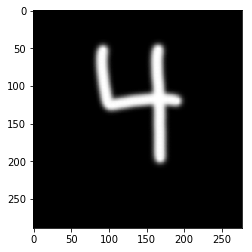

In [19]:
import matplotlib.image as mpimg
img=mpimg.imread('test.png')
plt.imshow(img[:, :, 0], cmap="gray")

In [20]:
test = np.expand_dims(np.expand_dims(img[:, :, 0], 2), 0)

In [22]:
batch_ys = np.array([4])
p = sess.run(logits, feed_dict={x_ph: test, y_ph: batch_ys})

In [23]:
print(np.argmax(p, axis=1))

[2]


In [24]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [27]:
print(data.train.images.shape)
train_input_fn(data.train.images, data.train.labels, 100)

(55000, 784)


ValueError: dictionary update sequence element #0 has length 784; 2 is required

In [46]:
train, test = tf.keras.datasets.mnist.load_data()
mnist_x, mnist_y = train

dataset = tf.data.Dataset.from_tensor_slices(train)
print(mnist_ds)

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>


In [48]:
itr = dataset.make_one_shot_iterator()

In [56]:
el = itr.get_next()

In [57]:
x, y = sess.run(el)
print(x.shape)
print(y.shape)
print(y)

(28, 28)
()
9


In [42]:
print(train[0].shape)
print(train[1].shape)

(60000, 28, 28)
(60000,)


In [43]:
print(test[0].shape)
print(test[1].shape)

(10000, 28, 28)
(10000,)


In [36]:
data.train.images.shape

(55000, 784)

In [44]:
print(mnist_ds.batch(100))

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.uint8, tf.uint8)>
